In [1]:
## plot within the notebook
%matplotlib inline
import warnings
import numpy as np
## No annoying warnings
warnings.filterwarnings('ignore')

In [2]:
from astrobject.utils.plot.skybins import SurveyFieldBins
ztf_fields = np.genfromtxt('data/ZTF_Fields.txt', comments='%')
bins = SurveyFieldBins(ra=ztf_fields[:,1], dec=ztf_fields[:,2])
# Fields are defined by their midpoints
# Default width and height are set to 7 degrees for now
# There is more field overlap the closer you get to the poles

In [3]:
field_idx = np.array([351, 352])
ra_range = (min(bins.ra[field_idx]) - 3.5, max(bins.ra[field_idx]) + 3.5)
dec_range = (min(bins.dec[field_idx]) - 3.5, max(bins.dec[field_idx]) + 3.5)
print ra_range
print dec_range

(-0.97059000000000006, 13.088240000000001)
(-13.28462, -6.2846200000000003)


In [4]:
import simsurvey.cadence as simul

In [5]:
# Make a mock survey plan (by no means realistic, just trying to capture the effect of
# moving the observed part of the sky along according to the seasons)
obs_days = np.arange(58000, 58090, 1)

bands = ['r_r_gggg', 'r_r_ggii']

obs = {'time': [], 'field': [], 'band': [], 'skynoise': []}
for k, d in enumerate(obs_days):
    for l, band in enumerate(bands[k%2]):
        if band != '_':
            for m, idx in enumerate(field_idx):
                if l <= 3 or (m == 0 and d < 58045) or (m == 1 and d >= 58045):
                    obs['time'].append(d + l / 86400.)
                    obs['field'].append(idx)
                    obs['band'].append('des%s'%band)
                    # Tuned to give 1% flux error at R=18 in combination with gain=0.25 
                    obs['skynoise'].append(400.) 
        
plan = simul.SurveyPlan(time=obs['time'], band=obs['band'], obs_field=obs['field'],
                        skynoise=obs['skynoise'],
                        fields=dict(ra=ztf_fields[:,1], dec=ztf_fields[:,2]))

In [6]:
tr = simul.get_sn_generator([0.01,0.1], ratekind="custom", ratefunc=lambda z: 1e-3,
                            mjd_range=[obs_days[0] - 60, obs_days[-1] + 25],
                            ra_range=ra_range, dec_range=dec_range)
print tr.ntransient
# ra_range and dec_range defined above
# ratekind is the rate of the transient: custom with constant rate of  1e-3 
# -> comoving volumetric rate at each redshift in units of yr^-1 Mpc^-3.
# Rate is exaggerated to get ~300 SNein the limited area and time
# This is for testing purposes

320


In [7]:
# SimulSurvey class collects all required components, Transient generator, survey plan and instruments
instprop = {"desg":{"gain":0.25,"zp":30,"zpsys":'ab',"err_calib": 0.005},
            "desr":{"gain":0.25,"zp":30,"zpsys":'ab',"err_calib": 0.005},
            "desi":{"gain":0.25,"zp":30,"zpsys":'ab',"err_calib": 0.005}}

# A random blinded offset can be added to all SNe
# The number passed to SimulSurvey sets the absolute bounds of a uniform distribution around zero,
# from which the bias is drawn 
blinded_bias = {'desg': 0.001, 'desr': 0.001, 'desi': 0.001}

In [8]:
survey = simul.SimulSurvey(generator=tr, plan=plan, instprop=instprop,
                           blinded_bias=blinded_bias)

SNe observed: 314 out of 320


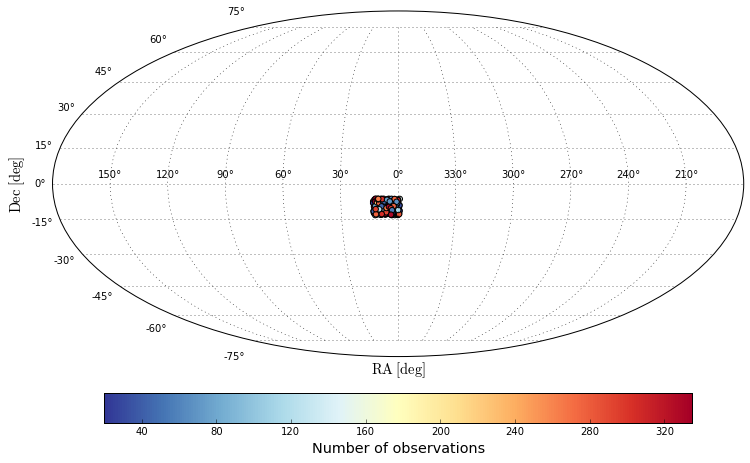

In [9]:
# Generate the lightcurves. This first determines the dates on which each transient was observed
# to keep the number of lightcurve points that are calculated to a minimum
lcs = survey.get_lightcurves()
n_obs = np.array([len(a) for a in survey.plan.observed])
survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of observations", mask=(n_obs > 0))
print 'SNe observed: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

In [10]:
lcs[:3]

[<Table length=18>
      time     band      flux         fluxerr      zp  zpsys
    float64    str4    float64        float64    int64  str2
 ------------- ---- -------------- ------------- ----- -----
       58081.0 desr  7.65730964165          20.0    30    ab
 58081.0000231 desr  30.6578083488          20.0    30    ab
       58082.0 desr  1.36301189897          20.0    30    ab
 58082.0000231 desr -21.9068829803          20.0    30    ab
       58083.0 desr  21.9631532999 20.0009213642    30    ab
 58083.0000231 desr -46.3845072188 20.0009214332    30    ab
       58084.0 desr  60.4299935401 20.0071273706    30    ab
 58084.0000231 desr  57.9759540644 20.0071276012    30    ab
       58085.0 desr  140.489900147 20.0210079317    30    ab
 58085.0000231 desr  102.564272978  20.021008364    30    ab
       58086.0 desr  227.083079146 20.0681020458    30    ab
 58086.0000231 desr  254.395034103 20.0681040466    30    ab
       58087.0 desr  694.497842585 20.3738037642    30    ab
 5808

In [16]:
# example lightcurve
lcs[2]

time,band,flux,fluxerr,zp,zpsys
float64,str4,float64,float64,int64,str2
58012.0,desr,-22.4435940158,20.0,30,ab
58012.0000231,desr,10.6471645253,20.0,30,ab
58012.0000463,desg,9.43544111855,20.0,30,ab
58012.0000579,desg,-24.2423346911,20.0,30,ab
58012.0000694,desg,-10.0708477524,20.0,30,ab
58012.000081,desg,-6.33805505087,20.0,30,ab
58013.0,desr,29.4776615425,20.0,30,ab
58013.0000231,desr,-1.56970936294,20.0,30,ab
58013.0000463,desg,-13.5403674494,20.0,30,ab


In [17]:
# Its parameters
lcs[2].meta

{'c': -0.14284527362300362,
 'dec': -12.980966649909377,
 'fluxcov': array([[  4.00000000e+02,   1.18610845e-34,   0.00000000e+00, ...,
          -1.75221171e-16,  -1.72047127e-16,  -1.72047059e-16],
        [  1.18610845e-34,   4.00000000e+02,   0.00000000e+00, ...,
          -1.75221171e-16,  -1.72047127e-16,  -1.72047059e-16],
        [  0.00000000e+00,   0.00000000e+00,   4.00000000e+02, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        ..., 
        [ -1.75221171e-16,  -1.75221171e-16,   0.00000000e+00, ...,
           6.74628010e+02,   2.54161406e+02,   2.54161305e+02],
        [ -1.72047127e-16,  -1.72047127e-16,   0.00000000e+00, ...,
           2.54161406e+02,   6.65054581e+02,   2.49557300e+02],
        [ -1.72047059e-16,  -1.72047059e-16,   0.00000000e+00, ...,
           2.54161305e+02,   2.49557300e+02,   6.65054378e+02]]),
 'mwebv': 0.041231308888457649,
 'mwebv_sfd98': 0.033315740525722504,
 'ra': 1.5769788370329048,
 't0': 58035.248194794331,


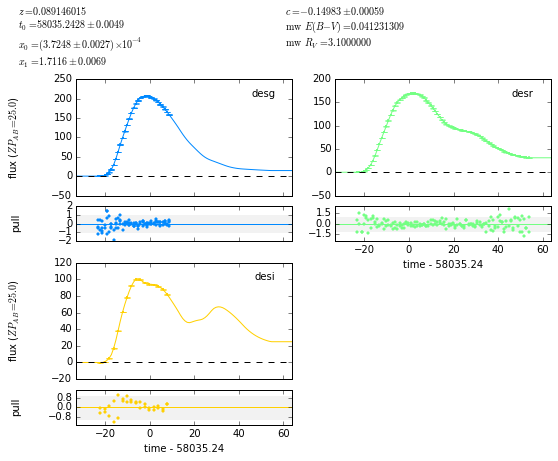

In [18]:
# Example lightcurve fit
lc = lcs[2]

import sncosmo
survey.generator.model.set(z=lc.meta['z'],mwebv=lc.meta['mwebv'])
res, fitted_model = sncosmo.fit_lc(lc, survey.generator.model, ['t0', 'x0', 'x1', 'c'])

_ = sncosmo.plot_lc(lc, model=fitted_model, errors=res.errors)

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7ff1b8719dd0>,
 'cbar': <matplotlib.colorbar.Colorbar instance at 0x7ff1b86a9680>,
 'figure': <matplotlib.figure.Figure at 0x7ff1b9db5ad0>,
 'plot': <matplotlib.collections.PathCollection at 0x7ff1b85fd750>}

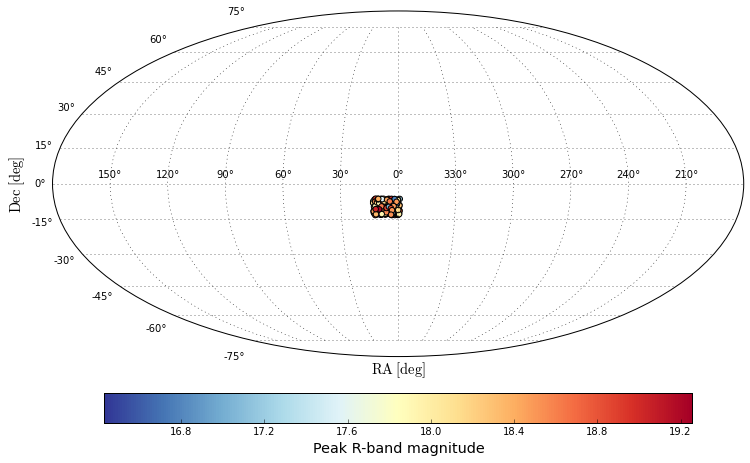

In [14]:
# MW E(B-V) is now automatically included in the lc model,
# so MW can be seen in magnitudes
peak_mag = survey.generator.get_bandmag(band='bessellr', magsys='vega', t=0) # t is time relative to t0
survey.generator.show_skycoverage(cscale=peak_mag, cblabel="Peak R-band magnitude", mask=(n_obs > 0))